In [4]:
import numpy as np
import matplotlib.pyplot as plt


### Data read-in

In [5]:
label_names = open("data/clsp.lblnames").read()
label_names = sorted(label_names.strip().split("\n")[1:])
assert(len(label_names) == 256)

# Get training labels
with open("data/clsp.trnlbls") as f:
    trnlbls = f.read()
trnlbls = trnlbls.split()[1:]
label_count_for_letter = [0 for _ in range(256)]
AACount = 0
JVCount = 0
for i in range(len(trnlbls)):
    label_count_for_letter[label_names.index(trnlbls[i])] += 1
    if trnlbls[i] == "AA":
        AACount += 1
    if trnlbls[i] == "JV":
        JVCount += 1
assert(AACount == label_count_for_letter[label_names.index("AA")])
assert(JVCount == label_count_for_letter[label_names.index("JV")])

total_count = sum(label_count_for_letter)
label_prob_for_letter = np.array([count / total_count for count in label_count_for_letter])


# get training labels for silence.
label_count_for_silence = [1 for _ in range(256)] # 1 to avoid 0 probability
with open("data/clsp.endpts") as f:
    endpts = f.read()
endpts = endpts.split("\n")[1:]
endpts = [list(map(int, line.split())) for line in endpts if line.strip()]

with open("data/clsp.trnlbls") as f:
    trnlbls = f.readlines()
trnlbls = [l.strip().split() for l in trnlbls[1:]]

assert len(trnlbls) == len(endpts)


for i in range(len(trnlbls)):
    start_end = endpts[i]
    # Using 1-indexing. might need to change according to problem.
    before = trnlbls[i][:start_end[0]]
    after = trnlbls[i][start_end[1] - 1:]
    for label in before:
        label_count_for_silence[label_names.index(label)] += 1
    for label in after:
        label_count_for_silence[label_names.index(label)] += 1
total_count_for_silence = sum(label_count_for_silence)
label_prob_for_silence = np.array([count / total_count_for_silence for count in label_count_for_silence])

letters = "abcdefghijlmnoprstuvwxy"
assert(len(letters) == 23)

with open("data/clsp.trnlbls") as f:
    trnlbls = f.readlines()
with open("data/clsp.trnscr") as f:
    trnscr = f.readlines()
trnscr = [scr.strip() for scr in trnscr[1:]]
trnlbls = [l.strip().split() for l in trnlbls[1:]]
assert(len(trnscr) == len(trnlbls))
labels_grouped_by_word = {}

for i in range(len(trnscr)):
    word = trnscr[i]
    labels = trnlbls[i]
    if word not in labels_grouped_by_word:
        labels_grouped_by_word[word] = []
    labels_grouped_by_word[word].append(np.array(labels))


all_items_count = 0
for k,v in labels_grouped_by_word.items():
    assert(len(v) >= 10 and len(v) <= 25)
    all_items_count += len(v)
assert(all_items_count == 798)


base_letter_transition = np.array([
    [.8, .2, .0],
    [0, .8, .2],
    [0,0,0.8]
])
silence_transition = np.array([
    [.25,.25,.25,.25,0],
    [0,.25,.25,.25,.25],
    [0,.25,.25,.25,.25],
    [0,.25,.25,.25,.25],
    [0,0,0,0,.75]
])


In [ ]:
class WordHMM:
    def __init__(self,
                 letter_emissions,
                 letter_transitions,
                 silence_emissions,
                 silence_transitions,
                 ordered_label_names,
                 ):
        
        self.letter_transitions_all = np.stack([letter_transitions] * 23)
        self.letter_emissions_all = np.tile(letter_emissions[:, np.newaxis, np.newaxis, np.newaxis], (1, 23, 3, 3))
        self.letter_null = np.array([.2] * 23)

        self.silence_emissions = np.tile(silence_emissions[:, np.newaxis, np.newaxis], (1, 5, 5))
        self.silence_transitions = silence_transitions
        self.silence_null = .25

        self.ordered_label_names = ordered_label_names
        self.letters = "abcdefghijlmnoprstuvwxy"

        self.log_per_epoch = []


        self.reset_counters()

    def reset_counters(self, use_soft_counts=True):
        # Using pseudo_count for smoothing instead of 0.
        #pc = 1e-10
        self.log_counter = 0.0
        if use_soft_counts:
            pc = 1e-10

            base_letter_transition = np.array([
                [pc, pc, .0],
                [0, pc, pc],
                [0,0,pc]
            ])
            silence_transition = np.array([
                [pc, pc, pc, pc, 0],
                [0, pc, pc, pc, pc],
                [0, pc, pc, pc, pc],
                [0, pc, pc, pc, pc],
                [0,0,0,0, pc]
            ])

            self.letter_counter = np.tile(base_letter_transition, (256, 23, 1, 1))
            self.silence_counter = np.tile(silence_transition, (256, 1, 1))
            self.letter_null_counter = np.ones(23) * pc
            self.silence_null_counter = pc

        else:
            self.letter_counter = np.zeros((256, 23, 3, 3))
            self.silence_counter = np.zeros((256,5,5))
            self.letter_null_counter = np.zeros(23)
            self.silence_null_counter = 0

    def create_word_transition(self, word):
        total_dim = len(word) * 3 + 10
        transition_matrix = np.zeros((total_dim, total_dim))
        transition_matrix[0:5, 0:5] = self.silence_transitions
        transition_matrix[-5:, -5:] = self.silence_transitions
        for i in range(len(word)):
            s_id = 5 + i * 3
            e_id = s_id + 3
            transition_matrix[s_id:e_id, s_id:e_id] = self.letter_transitions_all[self.letters.index(word[i])]
        return transition_matrix
    
    def create_null_transition(self, word):
        total_dim = len(word) * 3 + 10
        transition_matrix = np.zeros((total_dim, total_dim))
        transition_matrix[4,5] = self.silence_null
        transition_matrix[-1, -1] = self.silence_null
        for i in range(len(word)):
            null_position = 7 + i * 3
            transition_matrix[null_position, null_position + 1] = self.letter_null[self.letters.index(word[i])]
        return transition_matrix

    def create_emission_matrix(self, word, emission):
        total_dim = len(word) * 3 + 10
        emission_matrix = np.zeros((total_dim, total_dim))
        emission_index = self.ordered_label_names.index(emission)
        emission_matrix[0:5, 0:5] = self.silence_emissions[emission_index]
        emission_matrix[-5:, -5:] = self.silence_emissions[emission_index] #setting null transition to itself
        for i in range(len(word)):
            s_id = 5 + i * 3
            e_id = s_id + 3
            #print(self.letter_emissions_all[emission_index][self.letters.index(word[i])].shape)
            emission_matrix[s_id:e_id, s_id:e_id] = self.letter_emissions_all[emission_index][self.letters.index(word[i])]
        return emission_matrix
    
    def initialize_for_word(self, word):
        self.word_transition_matrix = self.create_word_transition(word)
        self.null_transition_matrix = self.create_null_transition(word)

    def forward_with_normalization(self, word, emissions, inference=False):
        total_state_count = len(word) * 3 + 10
        alpha = np.zeros((len(emissions) + 1, total_state_count))
        alpha[0,0] = 1
        q_values = np.zeros(len(emissions) + 1)
        q_values[0] = 1

        for t in range(1, len(emissions) + 1):
            emission_matrix = self.create_emission_matrix(word, emissions[t-1])
            alpha[t] = alpha[t-1] @ (self.word_transition_matrix * emission_matrix)
            if t != len(emissions):
                alpha[t] += alpha[t] @ self.null_transition_matrix
            q_values[t] = np.sum(alpha[t])
            alpha[t] /= q_values[t]
        if inference == False: # increment log counter only during training
            self.log_counter += (np.sum(np.log(q_values)) + np.log(alpha[-1,-1])) / len(emissions) 
        return alpha, q_values
    
    def backward_with_normalization(self, word, emissions, q_values):
        total_state_count = len(word) * 3 + 10
        beta = np.zeros((len(emissions) + 1, total_state_count))
        #beta[-1] = np.ones(total_state_count)
        beta[-1, -1] = 1

        for t in range(len(emissions) - 1, -1, -1):
            emission_matrix = self.create_emission_matrix(word, emissions[t])
            beta[t] = beta[t+1] @ (self.word_transition_matrix * emission_matrix).T
            if t != 0:
                beta[t] += beta[t] @ self.null_transition_matrix.T
            beta[t] /= q_values[t]
        return beta

    def BW_with_normalization(self, word, emissions):
        alpha, q_values = self.forward_with_normalization(word, emissions)
        beta = self.backward_with_normalization(word, emissions, q_values)

        for t in range(len(emissions)):
            emission_matrix = self.create_emission_matrix(word, emissions[t])
            forward_backward_outer = np.outer(alpha[t], beta[t+1])
            transition_emission = self.word_transition_matrix * emission_matrix
            posterior = forward_backward_outer * transition_emission
            #print(posterior)

            emission_index = self.ordered_label_names.index(emissions[t])
            #print(posterior[0:5, 0:5])
            self.silence_counter[emission_index] += posterior[0:5, 0:5]
            self.silence_counter[emission_index] += posterior[-5:, -5:]
            for i in range(len(word)):
                s_id = 5 + i * 3
                e_id = s_id + 3
                self.letter_counter[emission_index][self.letters.index(word[i])] += posterior[s_id:e_id, s_id:e_id]

            # update nulls
            forward_backward_outer = np.outer(alpha[t], beta[t])
            posterior_null = (forward_backward_outer * self.null_transition_matrix) * q_values[t]
            
            self.silence_null_counter += posterior_null[4, 5]
            self.silence_null_counter += posterior_null[-1, -1]
            #assert(posterior_null[-1,-1] == 0)
            for i in range(len(word)):
                null_position = 7 + i * 3
                self.letter_null_counter[self.letters.index(word[i])] += posterior_null[null_position, null_position + 1]
    def update_transitions(self):
        # update silence first silence is of dim 256,5, 5
        #print(self.silence_counter)
        silence_transition_squeezed_by_emission = np.sum(self.silence_counter, axis=0)
        #print(silence_transition_squeezed_by_emission)
        self.silence_emissions = np.divide(self.silence_counter,
                                           silence_transition_squeezed_by_emission,
                                           where=silence_transition_squeezed_by_emission != 0,
                                           out=np.zeros_like(self.silence_counter))

        
        # silence transition matrix
        silence_transition_sum_by_out = np.sum(silence_transition_squeezed_by_emission, axis = -1, keepdims=True) # sum over the rows
        last_self_loop = silence_transition_squeezed_by_emission[-1, -1] # last self loop for the last state in silence transition
        silence_transitions = np.divide(silence_transition_squeezed_by_emission,
                                       silence_transition_sum_by_out,
                                       out=np.zeros_like(silence_transition_squeezed_by_emission),
                                       where=silence_transition_sum_by_out != 0)
        
        #print("silence_null: ", self.silence_null_counter)
        #print("last_self_loop: ", last_self_loop)
        self.silence_null = self.silence_null_counter / (self.silence_null_counter + last_self_loop) # for the last state in silence transition
        silence_transitions[-1, -1] = 1 - self.silence_null # ensure last state self loop is 1
        self.silence_transitions = silence_transitions
        
        # update letter emissions
        letter_transition_squeezed_by_emission = np.sum(self.letter_counter, axis=0)
        self.letter_emissions_all = np.divide(self.letter_counter,
                                              letter_transition_squeezed_by_emission,
                                              where=letter_transition_squeezed_by_emission != 0,
                                              out=np.zeros_like(self.letter_counter))
        #print(self.letter_emissions_all.shape)
        #print(self.letter_emissions_all[:, 0, :, :]) # print the first letter emission for debugging
        
        # update letter transitions
        updated_transitions = np.zeros_like(self.letter_transitions_all)
        for i in range(len(letter_transition_squeezed_by_emission)):
            letter_transition = letter_transition_squeezed_by_emission[i]
            letter_transition_sum_by_out = np.sum(letter_transition, axis=-1, keepdims=True) # sum over the rows
            last_self_loop = letter_transition[-1, -1] # last self loop for the last state in letter transition
            letter_transitions = np.divide(letter_transition,
                                            letter_transition_sum_by_out,
                                            out=np.zeros_like(letter_transition),
                                            where=letter_transition_sum_by_out != 0)
            last_value = np.divide(last_self_loop, (self.letter_null_counter[i] + last_self_loop), where =(self.letter_null_counter[i] + last_self_loop) != 0,
                                  out=np.zeros_like(last_self_loop))
            letter_transitions[-1, -1] = last_value
            self.letter_null[i] = 1 - last_value
            updated_transitions[i] = letter_transitions # update the letter transition for this letter
        
        self.letter_transitions_all = updated_transitions
        
        
        



    def run_epoch(self, labels_grouped_by_word, reset_counters=False, print_log=False):
        counter = 0
        for word, labels in labels_grouped_by_word.items():
            self.initialize_for_word(word)
            for u in labels:
                self.BW_with_normalization(word, u)
                counter += 1
        self.update_transitions()
        
        average_log_per_word = self.log_counter / counter if counter > 0 else 0
        self.log_per_epoch.append(average_log_per_word))
        if print_log:
            print(f"Log counter: {self.log_counter}")
        if reset_counters:
            self.reset_counters()


    def run_multiple_epochs(self, labels_grouped_by_word, num_epochs):
        for _ in range(num_epochs):
            self.run_epoch(labels_grouped_by_word)
            print(f"Epoch {_+1} completed")
            print(f"Log counter: {self.log_counter}")
            if _ != 0:
                print(f"Negative Log Likelihood increased by: {self.log_per_epoch[-1] - self.log_per_epoch[-2] }")
                if self.log_per_epoch[-1] -self.log_per_epoch[-2] <-1e-10:
                    print("Convergence reached, stopping early.")
                    break
                    
            self.reset_counters()

    def print_matrix(self, matrix):
        for row in matrix:
            for element in row:
                print(f"{element:.6f}", end=" ")
            print()
    def get_log_per_iter(self):
        return self.log_per_epoch


In [14]:
w = WordHMM(
    label_prob_for_letter,
    base_letter_transition,
    label_prob_for_silence,
    silence_transition,
    label_names
)
w.run_multiple_epochs(labels_grouped_by_word=labels_grouped_by_word, num_epochs=100)

Epoch 1 completed
Log counter: -4178.598939782149
Epoch 2 completed
Log counter: -3632.380489258946
Negative Log Likelihood increased by: 546.2184505232026
Epoch 3 completed
Log counter: -3359.3339884640236
Negative Log Likelihood increased by: 273.0465007949224
Epoch 4 completed
Log counter: -3223.8431360681793
Negative Log Likelihood increased by: 135.49085239584429
Epoch 5 completed
Log counter: -3172.7122448222517
Negative Log Likelihood increased by: 51.130891245927614
Epoch 6 completed
Log counter: -3162.6459852186467
Negative Log Likelihood increased by: 10.066259603604976
Epoch 7 completed
Log counter: -3160.3676867578642
Negative Log Likelihood increased by: 2.27829846078248
Epoch 8 completed
Log counter: -3159.6604836986066
Negative Log Likelihood increased by: 0.7072030592576084
Epoch 9 completed
Log counter: -3158.292220308716
Negative Log Likelihood increased by: 1.3682633898906715
Epoch 10 completed
Log counter: -3156.982485553646
Negative Log Likelihood increased by: 1.3

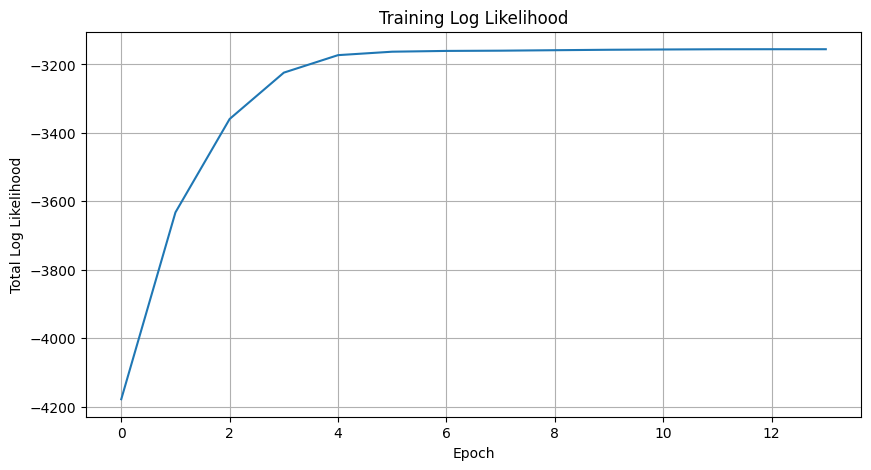

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(w.log_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Total Log Likelihood')
plt.title('Training Log Likelihood')
plt.grid(True)
plt.savefig('log_likelihood_plot_average.png')




### Test data evaluation

In [16]:
with open("data/clsp.devlbls") as f:
    devlbls = f.readlines()
devlbls = [l.strip().split() for l in devlbls[1:]]
print(len(devlbls))

with open("data/clsp.trnscr") as f:
    trnscr = f.readlines()
trnscr = [scr.strip() for scr in trnscr[1:]]
trnscr= sorted(set(trnscr))
print(len(trnscr))




393
48


In [17]:
log_outputs = np.zeros((len(trnscr), len(devlbls)))
for i, word in enumerate(trnscr):
    w.initialize_for_word(word)
    for j, lables in enumerate(devlbls):
        alpha, q_values = w.forward_with_normalization(word, lables)
        log_outputs[i, j] = (np.sum(np.log(q_values)) + np.log(alpha[-1,-1]))/ len(lables)




def softmax_0_axis(x):
    # Subtract max for numerical stability
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / np.sum(e_x, axis=0, keepdims=True)

def most_likely_and_prob(log_outputs, words):
    out = []
    prob_outputs = softmax_0_axis(log_outputs)
    max_prob_index = np.argmax(prob_outputs, axis=0)
    max_prob = np.max(prob_outputs, axis=0)
    for i in range(log_outputs.shape[1]):
        out.append((words[max_prob_index[i]], max_prob[i].item()))
    return out





In [18]:
most_likely = most_likely_and_prob(log_outputs, trnscr)
with open("most_likely_word_and_confidence.txt", "w") as f:
    for word, prob in most_likely:
        f.write(f"{word} {prob}\n")

## Discriminative Model

Implements the (i) model for contrastive system

In [23]:
def split_training_data(labels_grouped_by_word, split=0.8):
    train_data = {}
    held_out_data = {}
    for word, labels in labels_grouped_by_word.items():
        cut_range = int(len(labels) * split)
        train_data[word] = labels[:cut_range]
        held_out_data[word] = labels[cut_range:]
    return train_data, held_out_data

train_data, held_out_data = split_training_data(labels_grouped_by_word)


In [24]:
with open("data/clsp.trnscr") as f:
    trnscr = f.readlines()
trnscr = [scr.strip() for scr in trnscr[1:]]
trnscr= sorted(set(trnscr))
print(len(trnscr))

# Helper function to get accuracy on held out data
def get_accuracy(model, grouped_labels, trnscr):
    total_count = 0
    correct_count = 0
    for k, v in grouped_labels.items():
        prob_mat = np.zeros((len(trnscr), len(v)))
        word_idx = trnscr.index(k)
        for i, word in enumerate(trnscr):
            model.initialize_for_word(word)
            for j, label in enumerate(v):
                #print(label)
                alpha, q_values = model.forward_with_normalization(word, label, inference=True) # inference=True to avoid log counter increment
                #print(alpha.shape)
                prob_mat[i, j] = (np.sum(np.log(q_values)) + np.log(alpha[-1,-1])) / len(label)
        best_label = np.argmax(prob_mat, axis=0)
        # count number of word_idx in best_label
        correct_count += np.sum(best_label == word_idx)
        total_count += len(v)
    return correct_count / total_count







48


In [26]:
# Training 
def training_loop(model, train_data, held_out_data, max_epochs=100):
    accuracy_per_epoch = [0]
    for epoch in range(max_epochs):
        out = get_accuracy(model, held_out_data, trnscr)
        print(f"For epoch {epoch}, accuracy is {out}")
        model.run_epoch(train_data, reset_counters=True, print_log=True)
        out = get_accuracy(model, held_out_data, trnscr)
        if out < accuracy_per_epoch[-1]:
            return epoch + 1
        accuracy_per_epoch.append(out)



In [27]:
w = WordHMM(
    label_prob_for_letter,
    base_letter_transition,
    label_prob_for_silence,
    silence_transition,
    label_names
)

ep = training_loop(w, train_data, held_out_data, max_epochs=100)

For epoch 0, accuracy is 0.017241379310344827
Log counter: -3265.2218793359425
For epoch 1, accuracy is 0.5632183908045977
Log counter: -2833.581530489446
For epoch 2, accuracy is 0.6666666666666666
Log counter: -2618.853200823476
For epoch 3, accuracy is 0.7011494252873564
Log counter: -2514.767844043194
For epoch 4, accuracy is 0.7011494252873564
Log counter: -2472.1738766234157
For epoch 5, accuracy is 0.7068965517241379
Log counter: -2463.737242904095


In [ ]:
w.run_multiple_epochs(labels_grouped_by_word=labels_grouped_by_word, num_epochs=ep)

Epoch 1 completed
Log counter: -47.552218890554386
Epoch 2 completed
Log counter: -28.05021735577854
Negative Log Likelihood increased by: 19.502001534775847
Epoch 3 completed
Log counter: -22.503701590841008
Negative Log Likelihood increased by: 5.546515764937531
Epoch 4 completed
Log counter: -20.897193907896668
Negative Log Likelihood increased by: 1.6065076829443399


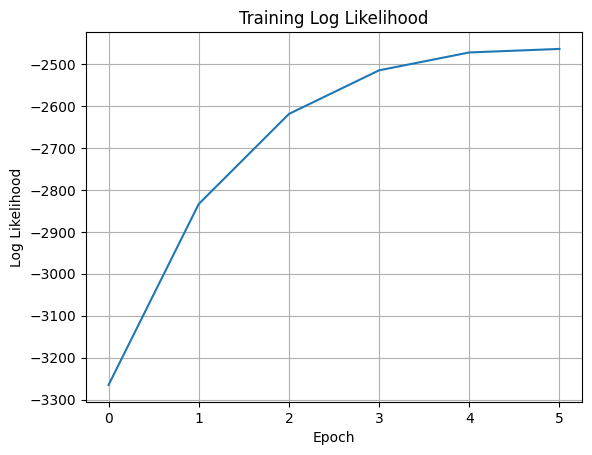

In [ ]:
plt.plot(w.log_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Log Likelihood')
plt.title('Training Log Likelihood')
plt.grid(True)
plt.savefig('log_likelihood_plot_contrastive_average.png')


In [36]:
ep = training_loop(w, train_data, held_out_data, max_epochs=100)

For epoch 0, accuracy is 0.05172413793103448
Log counter: -15.83097987621569
For epoch 1, accuracy is 0.034482758620689655
Log counter: -15.592268637778659


In [28]:
with open("data/clsp.devlbls") as f:
    devlbls = f.readlines()
devlbls = [l.strip().split() for l in devlbls[1:]]
print(len(devlbls))

log_outputs = np.zeros((len(trnscr), len(devlbls)))
for i, word in enumerate(trnscr):
    w.initialize_for_word(word)
    for j, lables in enumerate(devlbls):
        alpha, q_values = w.forward_with_normalization(word, lables)
        log_outputs[i, j] = (np.sum(np.log(q_values)) + np.log(alpha[-1,-1]))/ len(lables)




def softmax_0_axis(x):
    # Subtract max for numerical stability
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / np.sum(e_x, axis=0, keepdims=True)

def most_likely_and_prob(log_outputs, words):
    out = []
    prob_outputs = softmax_0_axis(log_outputs)
    max_prob_index = np.argmax(prob_outputs, axis=0)
    max_prob = np.max(prob_outputs, axis=0)
    for i in range(log_outputs.shape[1]):
        out.append((words[max_prob_index[i]], max_prob[i].item()))
    return out


most_likely = most_likely_and_prob(log_outputs, trnscr)
with open("most_likely_word_and_confidence_descriminative.txt", "w") as f:
    for word, prob in most_likely:
        f.write(f"{word} {prob}\n")


393


In [ ]:
w.log_

np.float64(-486.11443361755545)